In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sympy import symbols
from sympy.physics import mechanics

from sympy import Dummy, lambdify
from scipy.integrate import odeint


def integrate_pendulum(n, times,
                      initial_positions=145,
                      initial_velocities=0,
                      lenghts=None, masses=2):
    """integrate a multi-pend with 'n' sections"""
    
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))
    
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))
    
    g, t = symbols('g,t')
    
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A, 0)
    
    particles = []
    forces = [] 
    kinetic_odes = []
    
    for i in range(n):
        Ai = A.orientnew('A' + str(i), 'Axis' , [q[i], A.z])
        Ai.set_ang_vel(A, u[i]* A.z)
        
        Pi = P.locatenew('P' +str(i), l[i]* Ai.x)
        Pi.v2pt_theory(P, A, Ai)
        
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)
        
        forces.append((Pi, m[i] * g * A.x))
        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi
        
    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u,
                                   kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations(forces, particles)
        
    y0 =np.deg2rad(np.concatenate([np.broadcast_to(initial_positions, n),
                                  np.broadcast_to(initial_velocities, n)]))
        
        
        
    if lenghts is None:
        lenghts = np.ones(n) / n
            
    lenghts = np.broadcast_to(lenghts, n)
    masses = np.broadcast_to(masses, n)
        
    parameters= [g] + list(l) + list(m)
    parameter_vals = [9.807] + list(lenghts) +list(masses)
        
    unknowns = [Dummy() for i in q +u]
    unknown_dict = dict(zip(q +u, unknowns))
    kds = KM.kindiffdict()
        
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)
        
    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)
        
    def gradient(y, t, args):
        vals = np.concatenate((y, args))
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
        return np.array(sol).T[0]
        
    return odeint(gradient, y0, times, args=(parameter_vals,))
    
        

In [6]:
def get_xy_coords(p, lenghts=None):
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    if lenghts is None:
        lenghts = np.ones(n) / n
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lenghts * np.sin(p[:, :n])])
    y = np.hstack([zeros, -lenghts * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

C:\Users\cptnc\Anaconda3\envs\capstone\lib\site-packages\sympy\physics\mechanics\kane.py:533: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  issue=10945, deprecated_since_version="1.1").warn()


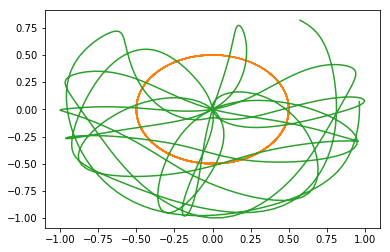

In [7]:
t = np.linspace(0, 10, 1000)
p = integrate_pendulum(n=2, times=t)
x, y = get_xy_coords(p)
plt.plot(x, y);

C:\Users\cptnc\Anaconda3\envs\capstone\lib\site-packages\sympy\physics\mechanics\kane.py:533: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  issue=10945, deprecated_since_version="1.1").warn()


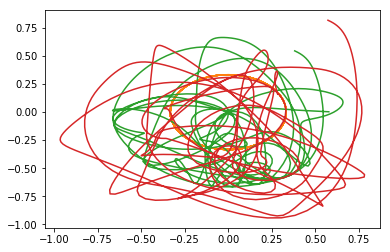

In [8]:
p = integrate_pendulum(n=3, times= t)
x,y = get_xy_coords(p)
plt.plot(x, y);

In [9]:
from matplotlib import animation


def animate_pendulum(n):
    t = np.linspace(0, 10, 200)
    p = integrate_pendulum(n, t)
    x, y = get_xy_coords(p)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    
    line, = ax.plot([],[], 'o-', lw=2)
    
    def init():
        line.set_data([],[])
        return line,
    
    def animate(i):
        line.set_data(x[i], y[i])
        return line,
    
    anim = animation.FuncAnimation(fig, animate, frames=len(t),
                                  interval=1000 * t.max() / len(t), blit=True, init_func=init)
                                  
    plt.close(fig)
    return anim
    

In [10]:
anim = animate_pendulum(3)

C:\Users\cptnc\Anaconda3\envs\capstone\lib\site-packages\sympy\physics\mechanics\kane.py:533: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  issue=10945, deprecated_since_version="1.1").warn()


In [ ]:
def inital_conditions(th1, th2, om1, om2):
    th1 = symbols('th1:{0}'.format(n))
    th2 = symbols('th2:{0}'.format(n))
    om1 = symbols('om1:{0}'.format(n))
    om2 = symbols('om2:{0}'.format(n))